<a href="https://colab.research.google.com/github/hayakzan/MLP-notations/blob/main/MLP_notations_GENERATING_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Before running the code
#### - Upload the notation fonts `/fonts/OpusStd.ttf` and `/fonts/OpusSpecialStd.ttf` into `/content` folder
#### - Upload `/xydata/train_xy.json` into `/content` folder


In [1]:
# -*- coding: utf-8 -*-

# dependencies
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import random
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from scipy import interpolate
import csv
import pandas as pd
import json


In [11]:
global fig_num
fig_num = 1

font_dirs = ["/content"]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

#TODO: fix the font issue
fontprop1 = fm.FontProperties(fname=font_files[1], size=24)
fontprop2 = fm.FontProperties(fname=font_files[0], size=25)



#### Create a JSON file for the parameters

In [3]:
# Create a list to store the slider values
slider_values_list = []

# Function to update the slider values
def update_slider_values(change):
    # Create a dictionary to store the slider values
    slider_values = {
        "speed": speed_slider.value,
        "size": size_slider.value,
        "range_low": range_slider.value[0],
        "range_hi": range_slider.value[1],
        "x_offset": x_offset_slider.value,
        "y_offset": y_offset_slider.value,
        "rhy_irr": irregularity_slider.value,
        "chord_num": chord_num_slider.value,
        "chord_size": chord_size_slider.value
    }

    # Append the slider values to the list
    slider_values_list.append(slider_values)

    # Write the updated data to the file
    with open("slider_values.json", "w") as file:
        json.dump(slider_values_list, file, indent=4)


In [4]:
def plot_note(rhythm, pitch, notes, accidental, x_off, acc_off, secundal_offset, pitch_offset, chord_type, index):

    # note
    plt.text((rhythm + 0.035) + x_off + secundal_offset, pitch + pitch_offset-((index)*chord_type), notes[0],
             fontproperties=fontprop2, color='black')

    # accidental
    plt.text((rhythm - 0.025) + acc_off + secundal_offset, pitch + pitch_offset-((index)*chord_type), random.choice(acc_sym),
             fontproperties=fontprop1, color='black')


#### Use the sliders to set up notational parameters


In [5]:
import ipywidgets as widgets
from IPython.display import display

layout = widgets.Layout(margin='0 0 10px 0', width='40%')

# Create a slider widget
speed_slider = widgets.FloatSlider(value=1.0, min=0.2, max=2.0, step=0.1, description='speed:', style={'description_width': '150px'}, layout=layout)
size_slider = widgets.IntSlider(value=8, min=2, max=12, step=1, description='size:', style={'description_width': '150px'}, layout=layout)
range_slider = widgets.IntRangeSlider(value=[0, 12], min=0, max=12, step=1, description='range:', style={'description_width': '150px'}, layout=layout)
x_offset_slider = widgets.FloatSlider(value=0.4, min=0.4, max=7.0, step=0.05, description='x offset:', style={'description_width': '150px'}, layout=layout)
y_offset_slider = widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.5, description='y offset:', style={'description_width': '150px'}, layout=layout)
irregularity_slider = widgets.FloatSlider(value=0.0, min=0.0, max=0.5, step=0.01, description='rhythmic irregularity:', style={'description_width': '150px'}, layout=layout)
chord_num_slider = widgets.IntSlider(value=0, min=0, max=size_slider.value, step=1, description='# of chords:', style={'description_width': '150px'}, layout=layout)
chord_size_slider = widgets.IntSlider(value=2, min=2, max=4, step=1, description='chord size:', style={'description_width': '150px'}, layout=layout)
chord_type_button = widgets.ToggleButtons(options=['Secundal', 'Tertian', 'Quartal', 'Mixed', 'Mixed within chord'], description='chord type:', disabled=False, button_style='info')
direction_box = widgets.ToggleButtons(options=['Mixed', 'Upwards', 'Downwards'], description='directionality:', disabled=False, button_style='info')
#poly_box = widgets.Checkbox(value=False, description='toggle polyphony', disabled=False, indent=True, layout=layout)

slider_box = widgets.VBox([speed_slider, size_slider, range_slider, x_offset_slider, y_offset_slider, irregularity_slider, chord_num_slider, chord_size_slider, chord_type_button, direction_box])

# Display the slider widget
display(slider_box)


#### After the initial run, run after here (`Cmd/Ctrl+F10`) after each new slider setting (no need to re-run the slider cell). This will add new data into `slider_values.json`

In [6]:
# constants & variables
seed_value = 1234
np.random.seed(seed_value)

x_off = x_offset_slider.value
phan_off = 0.46
y_off = 0.0

# staff lines
X_1, Y_1 = np.linspace(0.06, 10.345, 10), np.zeros(10)
# measure lines
X_2, Y_2 = np.linspace(0.06, 0.06, 10), np.linspace(4, 0, 10)

# notes:
noteheads = ['f', ' ']
notes = []
accidentals = []
acc_sym = ['n','#','b']
acc_rest = [ ] #TODO add this above

for i in range(len(noteheads)):
  notes.append(noteheads[i])

# arrays for data:
rhy_map = []
pi_map = []



In [7]:
## input etc. TODO: dataset input option
size = size_slider.value

#raw_data = pd.read_csv("/content/src/pix.csv", converters={"0": int})
#chars = raw_data["0"].values.tolist()

# Generate random values
range_slider_min = range_slider.value[0]
range_slider_max = range_slider.value[1]
raw_data = np.random.randint(low=range_slider_min, high=range_slider_max, size=size)


In [8]:
## Speed / rhythmic irregularity / textural direction

speed = speed_slider.value
mean = 0
std_dev = irregularity_slider.value

x_data = list(range(size))

# Add randomness
x_data = [x + np.random.normal(mean, std_dev) for x in x_data]
x_data = [i*speed for i in x_data]

y_data = raw_data

if direction_box.value == 'Mixed':
  pass
elif direction_box.value == 'Upwards':
  y_data = sorted(raw_data)
elif direction_box.value == 'Downwards':
  y_data = sorted(raw_data, reverse=True)
else:
    pass



#### Generate the notation

>=3 to <8
div start:  0
div end:  12


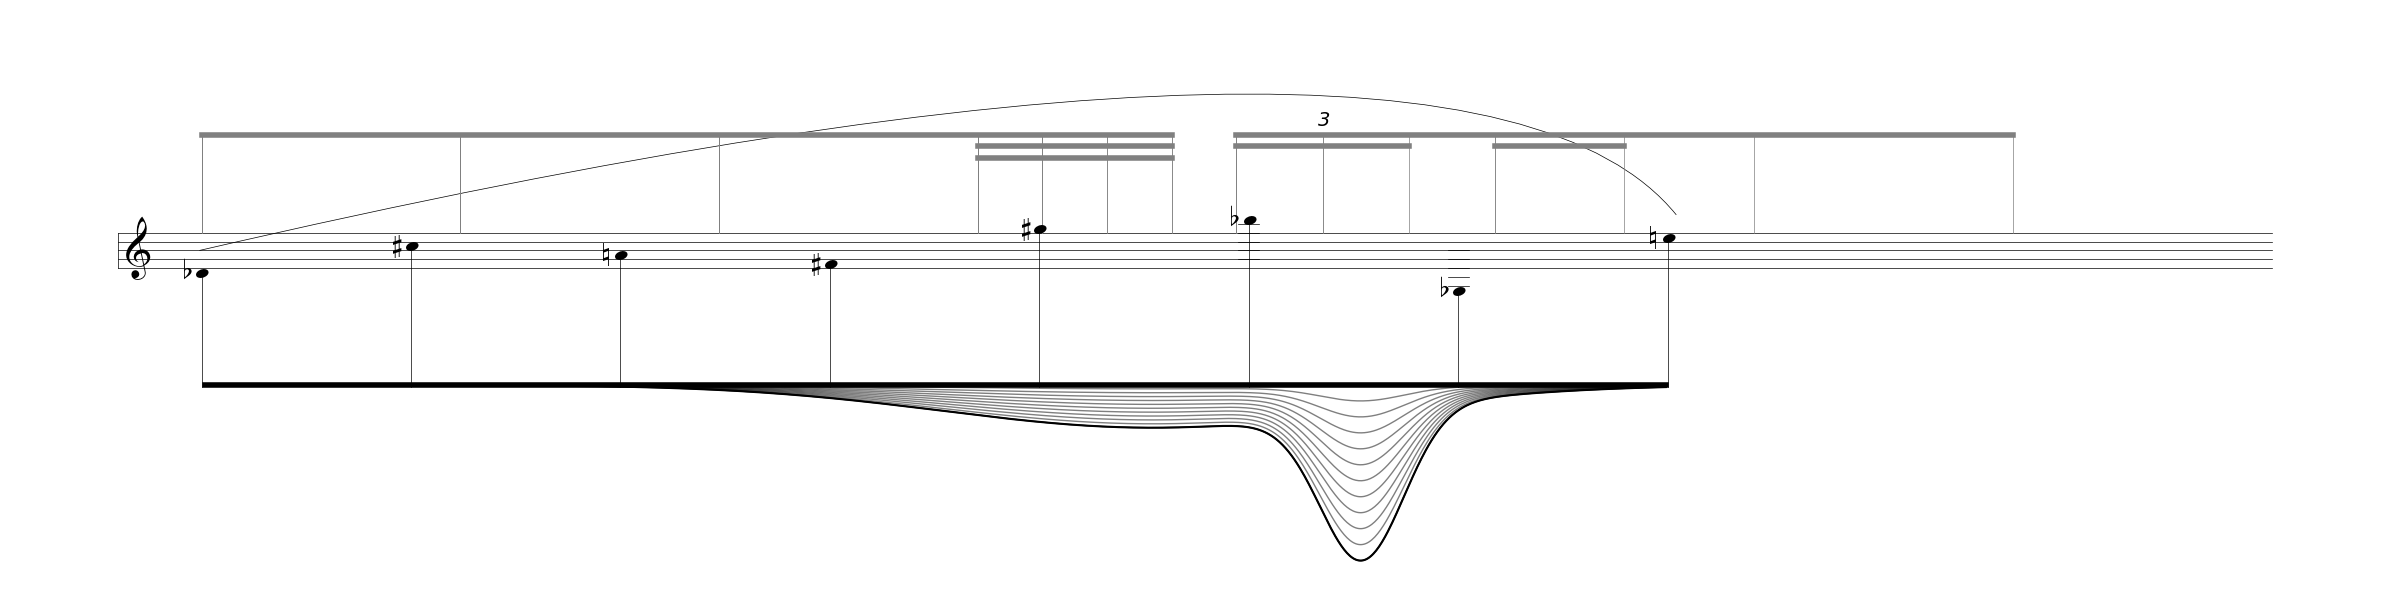

In [49]:
import warnings
# create the figure and subplot:
fig = plt.figure(figsize=(24, 6))
ax = plt.subplot(1, 1, 1)

# customize the subplot spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

accidentals = []
chord_type_list = []
rest_positions = []
rest_index = []

for j in range(size):
    # no sharps on Es in this context
    if y_data[j] % 3.5 == 0.0:
      accidentals.append(random.choice([acc_sym[0], acc_sym[2]]))
    # no flats on Fs in this context
    elif y_data[j] % 3.5 == 0.5:
      accidentals.append(random.choice(acc_sym[:2]))
    # no sharps on Bs in this context
    elif y_data[j] % 3.5 == 2.0:
      accidentals.append(random.choice([acc_sym[0], acc_sym[2]]))
    # no flats on Cs in this context
    elif y_data[j] % 3.5 == 2.5:
      accidentals.append(random.choice(acc_sym[:2]))
    else:
      accidentals.append(random.choice(acc_sym))

# chords
chord_indices = random.sample(range(0, size), chord_num_slider.value)
for chord in chord_indices:
  pitch = y_data[chord]+y_offset_slider.value
  pitch_offset = -3.55
  rhythm = x_data[chord]
  accidental = accidentals[chord]
  ledger_off_low = (pitch+pitch_offset)+0.55
  ledger_off_hi = (pitch+pitch_offset)-4.45
  rest_positions.append(x_data[chord])

  # second_arr = [left_second, right_second, left_second]

  for i in range(1, chord_size_slider.value):
    if chord_type_button.value == 'Secundal':
      chord_type = 0.5
      secundal_offset_left = 0.025
      secundal_offset_right = -0.035
      acc_off_1 = x_off-0.17
      acc_off_2 = x_off-0.06
      secundal_offset_array = [secundal_offset_left, secundal_offset_right, secundal_offset_left, secundal_offset_right]
      secundal_acc_offset_arr = [acc_off_1, acc_off_2, acc_off_1, acc_off_2-0.1]
      plot_note(rhythm, pitch, notes, accidental, x_off, secundal_acc_offset_arr[i], secundal_offset_array[i], pitch_offset, chord_type, i)

    elif chord_type_button.value == 'Tertian':
      chord_type = 1.0
      rest_positions = []
      plt.text((x_data[chord] + 0.035)+x_off, y_data[chord]+pitch_offset-(i*chord_type), notes[0], fontproperties=fontprop2, color='black')
      plt.text((x_data[chord] - 0.025)+x_off, y_data[chord]+pitch_offset-(i*chord_type), accidentals[chord], fontproperties=fontprop1, color='black')

    elif chord_type_button.value == 'Quartal':
      chord_type = 1.45
      rest_positions = []
      plt.text((x_data[chord] + 0.035)+x_off, y_data[chord]+pitch_offset-(i*chord_type), notes[0], fontproperties=fontprop2, color='black')
      plt.text((x_data[chord] - 0.025)+x_off, y_data[chord]+pitch_offset-(i*chord_type), accidentals[chord], fontproperties=fontprop1, color='black')

    elif chord_type_button.value == 'Mixed':
      plt.text((x_data[chord] + 0.035)+x_off, y_data[chord]+pitch_offset-(i*chord_type_list[chord]), notes[0], fontproperties=fontprop2, color='black')
      plt.text((x_data[chord] - 0.025)+x_off, y_data[chord]+pitch_offset-(i*chord_type_list[chord]), accidentals[chord], fontproperties=fontprop1, color='black')


    elif chord_type_button.value == 'Mixed within chord':
      chord_type = random.choice([0.5, 1.0, 1.45])
      plt.text((x_data[chord] + 0.035)+x_off, y_data[chord]+pitch_offset-(i*chord_type), notes[0], fontproperties=fontprop2, color='black')
      plt.text((x_data[chord] - 0.025)+x_off, y_data[chord]+pitch_offset-(i*chord_type), accidentals[chord], fontproperties=fontprop1, color='black')

      ax.plot(np.linspace(rhythm+x_off + 0.06, rhythm+x_off + 0.06, 10), np.linspace((pitch+pitch_offset), -13.3, 10), linestyle='solid', linewidth=0.5, color='black')

# Create a new array with 1s at specified positions and 0s elsewhere
rest_index = [1 if i in rest_positions else 0 for i in range(size)]

for i in range(size):
  pitch = y_data[i]+y_offset_slider.value
  pitch_offset = -3.55
  rhythm = x_data[i]
  accidental = accidentals[i]
  ledger_off_low = (pitch+pitch_offset)+0.55
  ledger_off_hi = (pitch+pitch_offset)-4.45
  chord_type_list.append(random.choice([0.5, 1.0, 1.45]))
  # ledger lines
  L1_x, L1_y = np.linspace(rhythm+x_off+0.01, rhythm++x_off+0.11, 10), np.full((10, ), ledger_off_low)
  L2_x, L2_y = np.linspace(rhythm+x_off+0.01, rhythm++x_off+0.11, 10), np.full((10, ), ledger_off_hi)

# main melody #TODO- use def
  if rest_index[i] == 1:
    plt.text((rhythm + 0.033)+x_off+0.03, pitch+pitch_offset, notes[0], fontproperties=fontprop2, color='black')
    plt.text((rhythm - 0.025)+x_off-0.04, pitch+pitch_offset, accidental, fontproperties=fontprop1, color='black')

  if rest_index[i] == 0:
    plt.text((rhythm + 0.035)+x_off+0.0, pitch+pitch_offset, notes[0], fontproperties=fontprop2, color='black')
    plt.text((rhythm - 0.025)+x_off+0.0, pitch+pitch_offset, accidental, fontproperties=fontprop1, color='black')

# stems
  ax.plot(np.linspace(rhythm+x_off + 0.06, rhythm+x_off + 0.06, 10), np.linspace((pitch+pitch_offset), -13.3, 10), linestyle='solid', linewidth=0.5, color='black')

  if pitch < 3.0 and (pitch % 1) == 0.0:
    for i in range(5):
      ax.plot(L1_x, L1_y + i, linestyle='solid', linewidth=0.5, color='black')
  elif pitch < 3.0 and (pitch % 1) != 0.0:
    for i in range(5):
      ax.plot(L1_x, L1_y-0.5 + i, linestyle='solid', linewidth=0.5, color='black')
  if pitch > 8.0 and (pitch % 1) == 0.0:
    for i in range(5):
      ax.plot(L2_x, L2_y + i, linestyle='solid', linewidth=0.5, color='black')
  elif pitch > 8.0 and (pitch % 1) != 0.0:
    for i in range(5):
      ax.plot(L2_x, L2_y+0.5 + i, linestyle='solid', linewidth=0.5, color='black')

# plot the staff lines
for i in range(5):
    ax.plot(X_1, y_off + Y_1 + i, linestyle='solid', linewidth=0.5, color='black')

# plot the treble clef
plt.text(0.1, 1.1 + y_off, '&', fontproperties=fontprop1)

# plot the measure lines and lower beams:
ax.plot(X_2, Y_2, linestyle='solid', linewidth=0.5, color='black')
ax.plot(np.linspace((x_data[0])+x_off + 0.075, (x_data[size-1])+x_off+ 0.05, 10), np.linspace(-13.1, -13.1, 10), linestyle='solid', linewidth=4, color='black')

# slur w/ Bezier curve
x_start, y_start = x_data[0], y_data[0]+y_offset_slider.value
x_end, y_end = x_data[size-1], y_data[size-1]+y_offset_slider.value

# control points for the Bezier
control_x, control_y = (x_data[0] + x_data[size-1]) - 0.5, (y_data[0]+y_offset_slider.value) + 32

# path of the Bezier
path = mpatches.Path([(x_start+0.45, y_start-1.0),
                      (control_x, control_y),
                      (x_end+0.5, y_end-1.0)], [1, 3, 3], closed=False)

patch = mpatches.PathPatch(path, edgecolor='black', facecolor='none', lw=0.5)

ax.add_patch(patch)





# phantom rhythms:
beat_start = 3
beat_end = 6

beat = 1.235
beats = []
divisions = [0.0]
tuplet_val = []
div_val = []
true_div_val = []
div_start = 0
div_end = 0
step = 1
total = 0
border = 0

# tuplet_val = [5, 2, 4, 3, 5, 3, 4, 2]

for i in range(8):
  beats.append(beat*i)
  tuplet_val.append(random.choice([1, 2, 3, 4, 5]))

  if i < beat_start or i > beat_end-1:
    tuplet_val[i] = 1
  div_val.append(1/tuplet_val[i])
  true_div_val.append(beat*div_val[i])

  for j in range(tuplet_val[i]):
    total += true_div_val[i]
    divisions.append(total)
divisions = divisions[:-1]

# print("beats: ", beats)
# print("divisions: ", divisions)
# print("tuplet_val: ", tuplet_val)
# print("beat_start", beat_start)
# print("beat_end", beat_end)
# print("total: ", total)


for i in range(beat_start, beat_end, step):
  p1 = beats[i]
  font = {'style': 'italic', 'size': 14}
  pair = [p1, p1+(true_div_val[i]*(tuplet_val[i]-1))] #true_div_val controls the interval
  border += tuplet_val[i]
  border = border+1
  div_start = 0
  div_end = border

  if tuplet_val[i] == 1:
    pass
  if tuplet_val[i] == 2:
    ax.plot(np.linspace(pair[0], pair[1], 10)+phan_off, np.linspace(13.7 + y_off, 13.7 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
    ax.plot(np.linspace(divisions[div_start:div_end:], divisions[div_start:div_end:], 10)+phan_off, np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')
  elif tuplet_val[i] == 3:
    ax.plot(np.linspace(pair[0], pair[1], 10)+phan_off, np.linspace(13.7 + y_off, 13.7 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
    ax.plot(np.linspace(divisions[div_start:div_end:], divisions[div_start:div_end:], 10)+phan_off, np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')
    ax.text(p1+0.85, 16, f'{tuplet_val[i]}', fontdict=font)
  elif tuplet_val[i] == 4:
    ax.plot(np.linspace(pair[0], pair[1], 10)+phan_off, np.linspace(13.7 + y_off, 13.7 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
    ax.plot(np.linspace(pair[0], pair[1], 10)+phan_off, np.linspace(12.4 + y_off, 12.4 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
    ax.plot(np.linspace(divisions[div_start:div_end:], divisions[div_start:div_end:], 10)+phan_off, np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')
  elif tuplet_val[i] == 5:
    ax.plot(np.linspace(pair[0], pair[1], 10)+phan_off, np.linspace(13.7 + y_off, 13.7 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
    ax.plot(np.linspace(pair[0], pair[1], 10)+phan_off, np.linspace(12.4 + y_off, 12.4 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
    ax.plot(np.linspace(divisions[div_start:div_end:], divisions[div_start:div_end:], 10)+phan_off, np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')
    ax.text(p1+0.92, 16, f'{tuplet_val[i]}', fontdict=font)

if beat_start < 2 and beat_end <= 3:
  print("<2 to <=3")
  #phantom beams
  ax.plot(np.linspace(beats[0], beats[3], 10)+phan_off, np.linspace(15 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
  ax.plot(np.linspace(beats[4], beats[7], 10)+phan_off, np.linspace(15 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=4, color='gray')

elif beat_start < 3 and beat_end == 8:
  print("<3 to 8")
  #phantom beams
  ax.plot(np.linspace(beats[0], beats[3]+(tuplet_val[3]*true_div_val[3])-true_div_val[3], 10)+phan_off, np.linspace(15 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
  ax.plot(np.linspace(beats[4], beats[7]+(tuplet_val[7]*true_div_val[7])-true_div_val[7], 10)+phan_off, np.linspace(15 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=4, color='gray')

elif beat_start >= 3 and beat_end == 8:
  print(">=3 to 8")
  #phantom beams
  ax.plot(np.linspace(beats[0], beats[3]+(tuplet_val[3]*true_div_val[3])-true_div_val[3], 10)+phan_off, np.linspace(15 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
  ax.plot(np.linspace(beats[4], beats[7]+(tuplet_val[7]*true_div_val[7])-true_div_val[7], 10)+phan_off, np.linspace(15 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=4, color='gray')

elif beat_start >= 3 and beat_end < 8:
  print(">=3 to <8")
  #phantom beams
  ax.plot(np.linspace(beats[0], beats[3]+(tuplet_val[3]*true_div_val[3])-true_div_val[3], 10)+phan_off, np.linspace(15 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
  ax.plot(np.linspace(beats[4], beats[7], 10)+phan_off, np.linspace(15 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=4, color='gray')

#phantom stems on beats
ax.plot(np.linspace(beats, beats, 10)+phan_off, np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')


print("div start: ", div_start)
print("div end: ", div_end)


# Add text to the plot
# ax.text(beats[0]+0.85, 16, '3', fontdict=font)

### TIMBRE ###
from matplotlib.colors import LinearSegmentedColormap

# Generate x values
x = np.linspace((x_data[0])+x_off + 0.075, (x_data[size-1])+x_off+ 0.05, 1000)
# Define the parameters for the Gaussian functions
mean1, mean2 = 5.0, 6.0
std_dev1, std_dev2 = 1.0, 0.2
amp1, amp2, amp3 = 0.4, 0.9, 0.5
amp1, amp2, amp3 = 12*amp1, 12*amp2, 12*amp3

# Calculate the y values using the Gaussian functions
y1 = amp1 * np.exp(-(x - mean1)**2 / (2 * std_dev1**2))
y2 = amp2 * np.exp(-(x - mean2)**2 / (2 * std_dev2**2))
y3 = amp3 * np.exp(-(x - mean2)**2 / (2 * std_dev2**2))


# Create the combined curve with multiple maxima
y = y1 + y2 + y3
y = -y
y = y-13.1

n = 10

# Plot the curve
plt.plot(x, y, color='black')

# # Generate x values
base_x = np.linspace((x_data[0])+x_off + 0.075, (x_data[size-1])+x_off+ 0.05, 1000)
base_y = np.linspace(-13.1, -13.1, 1000)

interpolations = np.linspace(0, 1, n+2)[1:-1]
interpolated_y = [np.interp(x, base_x, base_y + t * (y - base_y)) for t in interpolations]

# ######
# # Define the color gradient range and values
# color_start = 'black'
# color_end = 'white'

# # Create a linear grayscale color gradient colormap
# cmap = LinearSegmentedColormap.from_list('gradient', [color_start, color_end])

# # Normalize the y values to [0, 1]
# y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))


# # Plot the curve with gradual grayscale change using np.scatter
# for i, interpolated_curve in enumerate(interpolated_y):
#     color = cmap(y_norm)  # Calculate the color based on the normalized y values
#     ax.scatter(x, interpolated_curve, color=color, s=1)  # Adjust the marker size (scatter width) using the 's' parameter

# Plot the curve and interpolations
plt.plot(x, y, color='black', linewidth=1)
for i, interpolated_curve in enumerate(interpolated_y):
    plt.plot(x, interpolated_curve, color='black', alpha=0.5, linewidth=1)


# plt.plot(base_x, base_y, color='black', linewidth=1)  # Adjust the linewidth as desired

# set the y-axis limits, adjust layout, and display the plot:
warnings.filterwarnings("ignore", category=UserWarning)

ax.set_ylim(-35, 29)
fig.set_tight_layout(True)
plt.yticks([])
plt.xticks([])

# save if you want
#filename = f'notation_{fig_num}.jpg'
#plt.savefig(filename, format='jpg')
#fig_num += 1

plt.show()


In [10]:
|# update the slider values
update_slider_values(None)

SyntaxError: ignored

#### Check if the two datasets are of equal size by running the cell below. If they are not equal, you can generate more manually by `running before (cmd/ctrl + F8)` after setting up new slide values, or...

In [ ]:
# warn if the slider values are not equal to train_xy values

with open('train_xy.json') as file:
    train_xy = json.load(file)

x_train = train_xy['x']
y_train = train_xy['y']

with open('slider_values.json') as file:
    slider_values = json.load(file)

# Check if the sizes are equal
if len(x_train) != len(slider_values):
    print("Sizes of xy_train.json and slider_values.json are not equal.")
else: print("You're good to go!")

#### fill with random values by uncommenting and running `after the cell (Ctrl/Cmd+F10)` below.

In [ ]:
with open('train_xy.json') as file:
    train_xy = json.load(file)

x_train = train_xy['x']
y_train = train_xy['y']

with open('slider_values.json') as file:
    slider_values_data = json.load(file)

# check if the sizes are equal
if len(x_train) != len(slider_values_data):
    # Generate random values to fill slider_values_data
    while len(slider_values_data) < len(x_train):
        random_value = {
            "speed": round(random.random(), 2),
            "size": random.randint(1, 10),
            "range_low": random.randint(0, 10),
            "range_hi": random.randint(10, 20),
            "x_offset": round(random.random(), 2),
            "y_offset": round(random.random(), 2),
            "rhy_irr": round(random.random(), 2)
        }
        slider_values_data.append(random_value)

    with open('slider_values.json', 'w') as file:
        json.dump(slider_values_data, file, indent=4)


#### JSON files will be uploaded to your Google Drive (permission required)

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import shutil

# path to the source file
source_file_path_1 = '/content/train_xy.json'
source_file_path_2 = '/content/slider_values.json'

# destination directory in Google Drive
destination_directory = '/content/drive/MyDrive'

shutil.copy(source_file_path_1, destination_directory)
shutil.copy(source_file_path_2, destination_directory)